In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
get_size_weight(G, W, [0] * N, 744)

(4586, 110204.42095686684)

In [23]:
ids = [15487, 13896, 15671, 15996, 131454, 14930, 13923, 13932, 15720, 13949, 14104, 13934, 14791]
tested_ids = [id_[u] for u in ids]
tested_ids

[3692, 2113, 3876, 4201, 274, 3141, 2140, 2150, 3929, 2164, 2319, 2149, 3002]

In [24]:
tested_ids = set(tested_ids)
sample = []

V = [0] * N

Q = deque([744])
while Q and tested_ids:
    
    u = Q.popleft()
    
    if u in tested_ids:
        sample.append(u)
        
    for v in G.predecessors(u):
        if not V[v]:
            Q.append(v)
            V[v] = 1

print(sample)

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 274, 4201, 3876, 2113, 3002, 3692]


In [25]:
WI = {}
V = [0] * N
for u in sample[::-1]:
    s, w = get_size_weight(G, W, V, u)
    s, wr = get_size_weight_robust(G, W, V, 744, u)
    WI[_id[u]] = w
    V, _ = visit(G, V, u)
    print(_id[u], round(w, 1), round(wr, 1), round(get_size_weight(G, W, [0] * N, u)[1], 1), round(get_size_weight_robust(G, W, [0] * N, 744, u)[1], 1))

15487 2276.7 548.4 2276.7 548.4
14791 6908.4 6908.4 6908.4 6908.4
13896 98.3 98.3 1826.7 98.3
15671 5905.6 5692.0 12813.9 12600.4
15996 10364.9 10253.2 10540.8 10253.2
131454 14096.2 7419.6 39650.2 7419.6
14930 4881.1 4665.7 5393.5 4665.7
13923 3680.9 3680.9 9074.4 8562.0
13932 8696.6 7428.6 8696.6 7428.6
15720 13999.8 12752.6 13999.8 12752.6
13949 8502.0 8502.0 9770.0 8502.0
14104 8581.6 8581.6 8581.6 8581.6
13934 22212.1 22212.1 110204.4 110204.4


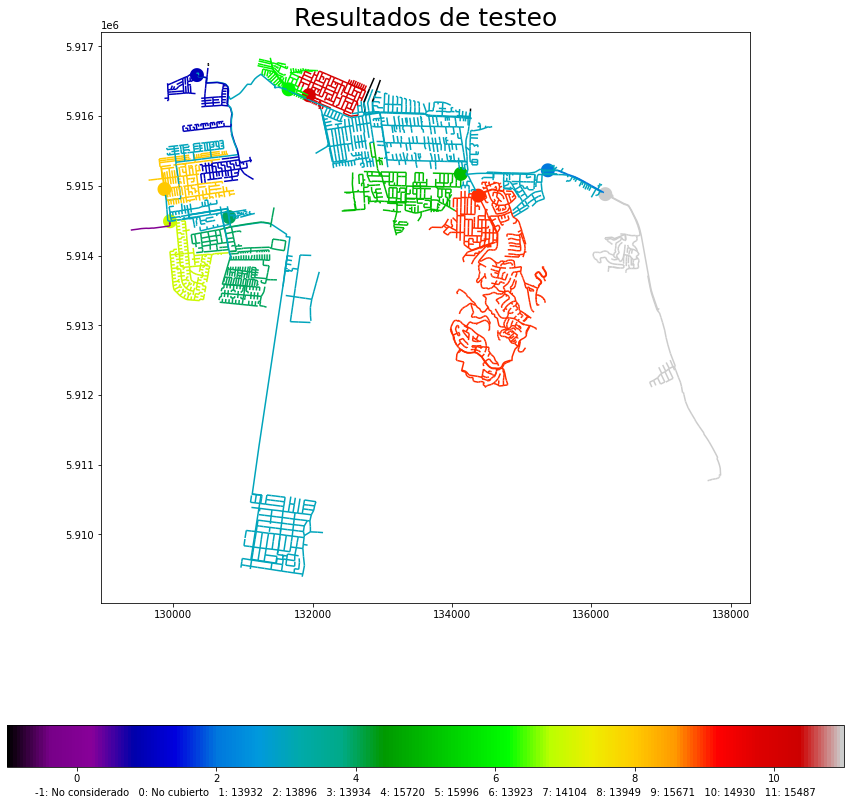

In [7]:
def plot_sample_no_intersections(G, V_, sample, geom, _id, name):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1
            
    newC = list(range(len(sample)))
    random.shuffle(newC)
    for u in range(N):
        if C[u] > 0:
            C[u] = newC[C[u] - 1] + 1
            
    newC_ = [0] * len(newC)
    for i in range(len(newC)):
        newC_[newC[i]] = i

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    
    for i in range(len(coord)):
        coord[i] = coord[i].buffer(100)
    
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i + 1] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [newC[i] + 1]

    label_ids = "   ".join([f"{i + 1}: {_id[sample[newC_[i]]]}" for i in range(len(sample))])
        
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': f"-1: No considerado   0: No cubierto   "+ label_ids, 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.savefig(name)

plot_sample_no_intersections(G, [0] * N, sample[::-1] , geometry, _id, "map")

In [8]:
DG = nx.DiGraph()

ss = set(sample)

for r in sample:
    
    V = [0] * N
    
    Q = deque([r])
    while Q:
        
        u = Q.popleft()
        
        for v in G.predecessors(u):
            if not V[v] and v not in ss:
                Q.append(v)
                V[v] = 1
            if not V[v] and v in ss:
                DG.add_edge(_id[r], _id[v])
                V, _ = visit(G, V, v)

In [9]:
print(DG.edges())

[(13934, 14104), (13934, 13949), (13934, 15720), (13934, 13932), (13934, 13923), (13934, 15996), (13934, 15671), (13934, 13896), (13934, 15487), (13923, 14930)]


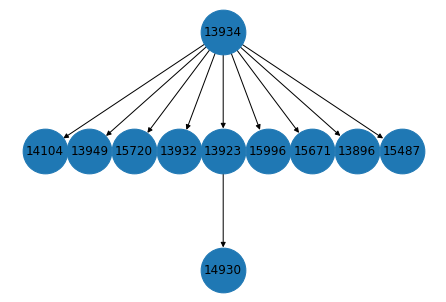

In [10]:
pos = graphviz_layout(DG, prog="dot")
nx.draw(DG, pos, with_labels=True, node_size=2000)
plt.savefig("tree")

In [11]:
P = {
    15671: 0, 
    13934: 4800, 
    13896: 303, 
    13923: 401.65, 
    13949: 283.38, 
    15996: 0,
    14104: 99.5,
    13932: 4740,
    14930: 470, 
    15487: 7530,
    15720: 1030
    }

In [12]:
Vals = {_id[u]: P[_id[u]] * get_size_weight(G, W, [0] * N, u)[1] for u in sample[::-1]}

In [13]:
for u in sample:
    for v in DG.successors(_id[u]):
        if Vals[_id[u]] < Vals[v]:
            print("ERROR")
            print(_id[u], v, Vals[_id[u]], Vals[v])